In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
#sys.path.append('/work/qdiff/mo_utils')
sys.executable


'/home/nadavg/anaconda3/envs/qdiff/bin/python'

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
#from mo_utils.utils.torch_utils import torch_to_pt,create_torch_script
import netron
from pathlib import Path

In [5]:
from qdiff import (
    QuantModel, QuantModule,QuantOp ,BaseQuantBlock,
    block_reconstruction, layer_reconstruction,
)
from qdiff.utils import resume_cali_model, get_train_samples


In [6]:
from scripts.gen_image import gen_image_from_prompt

In [7]:
import torch
import torch.nn as nn
from omegaconf import OmegaConf
from txt2img import load_model_from_config
from pytorch_lightning import seed_everything
from ldm.models.diffusion.plms import PLMSSampler
from qdiff.quant_layer import UniformAffineQuantizer
from qdiff.adaptive_rounding import AdaRoundQuantizer
import numpy as np
import matplotlib.pyplot as plt
from mo_utils.utils.plot_aux import plot_hist, myim


/home/nadavg/anaconda3/envs/qdiff/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/nadavg/anaconda3/envs/qdiff/lib/python3.8/site-packages/transformers/modeling_utils.py:371: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

libtmux not installed ??


In [8]:
config = OmegaConf.load(f'{Path.home()}/q-diffusion/configs/stable-diffusion/v1-inference.yaml')
model = load_model_from_config(config, "/fastdata/users/nadavg/sd/qdiff/sd-v1-4.ckpt")
device = torch.device("cuda")
model = model.to(device)
sampler = PLMSSampler(model)

/home/nadavg/q-diffusion/scripts/txt2img.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_sd = torch.load(ckpt, map_location="cpu")


LatentDiffusion: Running in eps-prediction mode


/home/nadavg/anaconda3/envs/qdiff/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/nadavg/anaconda3/envs/qdiff/lib/python3.8/site-packages/transformers/modeling_utils.py:371: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

In [9]:
import gc
gc.collect()

94

In [10]:
import yaml
prompts  = yaml.load(
                open(f'{Path.home()}/q-diffusion/scripts/prompt.yaml','r'),Loader=yaml.FullLoader
    )

In [19]:
orig_dataset = torch.load("/fastdata/users/nadavg/sd/qdiff/sd_coco-s75_sample1024_allst.pt")
orig_dataset.keys()

/tmp/ipykernel_2335722/3014383753.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig_dataset = torch.load("/fastdata/users/nadavg/sd/qdiff/sd_coco-s75_sample1024_allst

dict_keys(['xs', 'ts', 'cs', 'ucs', 'prompts'])

In [24]:
(len(orig_dataset['prompts']),orig_dataset['prompts'][0],
orig_dataset['xs'].shape, orig_dataset['ts'].shape, orig_dataset['cs'].shape,orig_dataset['ucs'].shape)

(1024,
 'three people riding on the backs of elephants ',
 torch.Size([50, 1024, 4, 64, 64]),
 torch.Size([50, 1024]),
 torch.Size([50, 1024, 77, 768]),
 torch.Size([50, 1024, 77, 768]))

In [11]:
len(prompts)#[0]

16

In [192]:
len(orig_dataset['prompts'])

1024

In [96]:
#prompt = "a puppy wearing a hat"
#seed = 42

#prompt = prompts[0]['prompt']
#seed = prompts[0]['seed']

prompt = orig_dataset['prompts'][1]
seed = 42


In [65]:
# Hook function to store inputs inside the model
def save_input_hook(module, input, output):
    if not hasattr(module, "saved_inputs"):
        module.saved_inputs = []  # Create attribute if not exists
    print(f"Saving input # {len(module.saved_inputs)}")
    module.saved_inputs.append(input)  # Append inputs to the model itself



In [66]:
type(model.model.diffusion_model)

ldm.modules.diffusionmodules.openaimodel.UNetModel

In [67]:
# Register hook on the entire model
handle = model.model.diffusion_model.register_forward_hook(save_input_hook)

In [ ]:
#handle.remove()
#model.model.diffusion_model._forward_hooks.clear()

In [97]:
model.model.diffusion_model.saved_inputs =[]

In [98]:
seed_everything(seed)
grid = gen_image_from_prompt(model,sampler,prompt,ddim_steps=50,n_samples=1,n_iter=1)
grid = np.array(grid)

Global seed set to 42
Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 50 timesteps


Running PLMS Sampling with #step 0
Saving input # 0
Saving input # 1
Running PLMS Sampling with #step 1
Saving input # 2
Running PLMS Sampling with #step 2


Saving input # 3
Running PLMS Sampling with #step 3
Saving input # 4
Running PLMS Sampling with #step 4
Saving input # 5
Running PLMS Sampling with #step 5
Saving input # 6
Running PLMS Sampling with #step 6


Saving input # 7
Running PLMS Sampling with #step 7
Saving input # 8
Running PLMS Sampling with #step 8
Saving input # 9
Running PLMS Sampling with #step 9
Saving input # 10
Running PLMS Sampling with #step 10


Saving input # 11
Running PLMS Sampling with #step 11
Saving input # 12
Running PLMS Sampling with #step 12
Saving input # 13
Running PLMS Sampling with #step 13
Saving input # 14
Running PLMS Sampling with #step 14


Saving input # 15
Running PLMS Sampling with #step 15
Saving input # 16
Running PLMS Sampling with #step 16
Saving input # 17
Running PLMS Sampling with #step 17
Saving input # 18
Running PLMS Sampling with #step 18


Saving input # 19
Running PLMS Sampling with #step 19
Saving input # 20
Running PLMS Sampling with #step 20
Saving input # 21
Running PLMS Sampling with #step 21
Saving input # 22
Running PLMS Sampling with #step 22


Saving input # 23
Running PLMS Sampling with #step 23
Saving input # 24
Running PLMS Sampling with #step 24
Saving input # 25
Running PLMS Sampling with #step 25
Saving input # 26
Running PLMS Sampling with #step 26


Saving input # 27
Running PLMS Sampling with #step 27
Saving input # 28
Running PLMS Sampling with #step 28
Saving input # 29
Running PLMS Sampling with #step 29
Saving input # 30
Running PLMS Sampling with #step 30


Saving input # 31
Running PLMS Sampling with #step 31
Saving input # 32
Running PLMS Sampling with #step 32
Saving input # 33
Running PLMS Sampling with #step 33
Saving input # 34
Running PLMS Sampling with #step 34


Saving input # 35
Running PLMS Sampling with #step 35
Saving input # 36
Running PLMS Sampling with #step 36
Saving input # 37
Running PLMS Sampling with #step 37
Saving input # 38
Running PLMS Sampling with #step 38


Saving input # 39
Running PLMS Sampling with #step 39
Saving input # 40
Running PLMS Sampling with #step 40
Saving input # 41
Running PLMS Sampling with #step 41
Saving input # 42
Running PLMS Sampling with #step 42


Saving input # 43
Running PLMS Sampling with #step 43
Saving input # 44
Running PLMS Sampling with #step 44
Saving input # 45
Running PLMS Sampling with #step 45
Saving input # 46
Running PLMS Sampling with #step 46




PLMS Sampler: 100%|██████████| 50/50 [00:03<00:00, 16.34it/s]

Saving input # 47
Running PLMS Sampling with #step 47
Saving input # 48
Running PLMS Sampling with #step 48
Saving input # 49
Running PLMS Sampling with #step 49
Saving input # 50



Sampling: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

None: Keep using EMA weights


In [115]:
len(model.model.diffusion_model.saved_inputs)

51

In [122]:
orig_dataset['xs'].shape,orig_dataset['ts'].shape,orig_dataset['cs'].shape,orig_dataset['ucs'].shape

(torch.Size([50, 1024, 4, 64, 64]),
 torch.Size([50, 1024]),
 torch.Size([50, 1024, 77, 768]),
 torch.Size([50, 1024, 77, 768]))

In [146]:
orig_dataset['prompts']

['three people riding on the backs of elephants ',
 'Person driving a plated motorcycle on a track with people watching.',
 'A cat sitting in front of a flat screen TV.',
 'A person is on a rail performing stunts on a skateboard.',
 'A person on surfboard riding on a small wave.',
 'A cat eating a dead bird on the ground.',
 'Two sinks in a kitchen with dirty dishes in them.',
 'A couple of people that are standing near a train.',
 'A young boy is performing tricks on a skateboard.',
 'A tan bathroom with a toliet and a tub.',
 'A bean and corn mixture, rice, and broccoli on a plate',
 'a little dog jumping up towards a frisbee someone is holding',
 'A modest plate with grains and broccoli and almonds',
 '4 different colored sea horses flying with 4 birds.',
 'People are walking by a blue train next to a mountain.',
 'a guy looking to the side and smiling',
 'Two people using an interactive gaming system while a person observes them from a couch.',
 'A fancy bathroom with a clean toile

In [118]:
saved_inputs = model.model.diffusion_model.saved_inputs

In [121]:
saved_inputs[0][0].shape,saved_inputs[0][1].shape,saved_inputs[0][2].shape

(torch.Size([2, 4, 64, 64]), torch.Size([2]), torch.Size([2, 77, 768]))

In [177]:
def get_inputs_dict_from_hook(saved_inputs,prompt=[]):
    #saved_inputs.pop(1)
    
    inputs_dict = {'xs':[],'ts':[],'cs':[],'ucs':[]}
    for i in range(len(saved_inputs)):
        if i == 1:
            continue
        inputs_dict['xs'].append(saved_inputs[i][0][:1])
        inputs_dict['ts'].append(saved_inputs[i][1][:1])
        inputs_dict['cs'].append(saved_inputs[i][2][1:2])
        inputs_dict['ucs'].append(saved_inputs[i][2][:1])
    for k in inputs_dict.keys():
        inputs_dict[k] = torch.cat(inputs_dict[k],dim=0).unsqueeze(1)
    inputs_dict['prompts']=[]    
    inputs_dict['prompts'].append(prompt)
    return inputs_dict
    

In [178]:
inputs_dict = get_inputs_dict_from_hook(saved_inputs,prompt)
inputs_dict_i = get_inputs_dict_from_hook(saved_inputs,prompt)


In [179]:
print(inputs_dict_i.keys())
inputs_dict_i['xs'].shape,inputs_dict_i['ts'].shape,inputs_dict_i['cs'].shape,inputs_dict_i['ucs'].shape

dict_keys(['xs', 'ts', 'cs', 'ucs', 'prompts'])


(torch.Size([50, 1, 4, 64, 64]),
 torch.Size([50, 1]),
 torch.Size([50, 1, 77, 768]),
 torch.Size([50, 1, 77, 768]))

In [180]:
def agragate_inputs_dict(inputs_dict,inputs_dict_i):
    for k in inputs_dict.keys():
        if k == 'prompts':
            continue
        inputs_dict[k] = torch.cat([inputs_dict[k],inputs_dict_i[k]],dim=1)
    inputs_dict['prompts'].extend(inputs_dict_i['prompts'])
    return inputs_dict

In [181]:
inputs_dict = agragate_inputs_dict(inputs_dict,inputs_dict_i)

In [182]:
print(inputs_dict.keys())
inputs_dict['xs'].shape,inputs_dict['ts'].shape,inputs_dict['cs'].shape,inputs_dict['ucs'].shape

dict_keys(['xs', 'ts', 'cs', 'ucs', 'prompts'])


(torch.Size([50, 2, 4, 64, 64]),
 torch.Size([50, 2]),
 torch.Size([50, 2, 77, 768]),
 torch.Size([50, 2, 77, 768]))

In [184]:
inputs_dict['prompts']

['Person driving a plated motorcycle on a track with people watching.',
 'Person driving a plated motorcycle on a track with people watching.']

In [100]:
model.model.diffusion_model.saved_inputs[0][0]

tensor([[[[ 0.1940,  2.1614, -0.1721,  ..., -0.8146,  0.2502, -0.4273],
          [ 1.1044, -1.1028,  0.5543,  ..., -1.2072, -0.2438, -0.6784],
          [ 0.1973,  0.9782, -0.0287,  ..., -0.1266, -0.4321, -1.3943],
          ...,
          [-1.1998,  0.5818, -0.7198,  ..., -0.6079, -1.8145,  0.2807],
          [-0.0970,  0.9319, -0.4393,  ..., -0.1155, -0.0528,  1.1175],
          [ 3.0098,  1.3304, -1.1632,  ...,  0.1124,  0.2769, -1.2535]],

         [[ 1.1346, -0.6329, -0.9147,  ..., -1.5122, -1.1374,  0.7628],
          [ 0.9661, -0.0587, -0.2129,  ...,  1.2377,  0.5842,  1.6728],
          [ 0.7942,  0.3131, -0.3607,  ...,  0.1261, -0.1309,  2.0342],
          ...,
          [-0.3319,  0.8590,  0.7535,  ..., -1.2910, -0.3644,  0.9805],
          [-0.5130,  0.6719, -0.1551,  ..., -0.4551, -0.1417, -1.2772],
          [-0.4063,  0.0820,  0.8311,  ..., -1.0449,  1.5397, -2.0042]],

         [[-0.5852, -0.9346,  0.9684,  ...,  0.5966, -1.6748,  1.7517],
          [-0.5635,  0.6796, -

In [101]:
model.model.diffusion_model.saved_inputs[0][0][0]-model.model.diffusion_model.saved_inputs[0][0][1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

'Person driving a plated motorcycle on a track with people watching.'

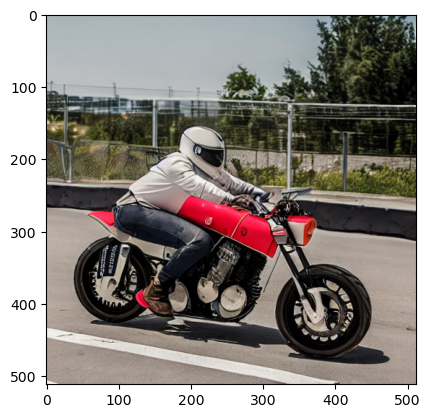

In [103]:
plt.imshow(grid)
prompt

In [ ]:
#[len(x) for x in model.model.diffusion_model.saved_inputs]
model.model.diffusion_model.saved_inputs[0][0].shape , orig_dataset['xs'].shape

(torch.Size([2, 4, 64, 64]), torch.Size([50, 1024, 4, 64, 64]))

In [114]:
orig_dataset['xs'][0][1] - model.model.diffusion_model.saved_inputs[0][0][0].cpu().numpy()

tensor([[[ 0.8481, -3.3593,  1.0134,  ...,  1.5018, -1.3448,  0.7819],
         [-2.7966,  1.8388, -0.9035,  ...,  0.3929,  0.5334,  0.4457],
         [-1.2421, -1.6150, -0.8856,  ...,  0.2678,  0.1673,  1.1075],
         ...,
         [-0.8371, -1.0146,  0.4947,  ...,  0.2206,  2.5909,  0.0735],
         [-1.0041, -0.5861,  0.7011,  ..., -1.2420,  0.8151, -2.3862],
         [-2.5476, -0.7285,  2.4112,  ..., -0.5924,  0.9699, -0.0877]],

        [[-1.8621,  1.7128,  1.4685,  ...,  0.9901,  0.8817, -0.3200],
         [-1.9477,  0.2052, -1.2817,  ..., -0.9005, -1.3435, -4.1236],
         [-0.6556,  0.0578,  0.0524,  ..., -1.4537, -0.1393, -1.2967],
         ...,
         [ 2.3427, -1.8500, -2.3086,  ...,  0.3488,  0.0379,  0.1718],
         [-0.1490, -1.0939,  0.7281,  ...,  0.8640, -0.9574,  2.3287],
         [-0.0720, -1.3974, -1.0821,  ...,  1.0094,  0.8458,  1.4607]],

        [[ 0.8886,  1.1608, -0.8030,  ..., -1.4483,  0.5348, -3.0781],
         [ 0.1782, -1.4467, -1.3152,  ...,  2

In [185]:
cds50= torch.load('../calib_dict_steps50.pt')

/tmp/ipykernel_2335722/232307477.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cds50= torch.load('../calib_dict_steps50.pt')


In [188]:
cds50.keys()

dict_keys(['xs', 'ts', 'cs', 'ucs', 'prompts'])

In [191]:
cds50['prompts']

['three people riding on the backs of elephants ',
 'Person driving a plated motorcycle on a track with people watching.',
 'A cat sitting in front of a flat screen TV.']

In [190]:
cds50['xs'].shape,cds50['ts'].shape,cds50['cs'].shape,cds50['ucs'].shape,cds50['prompts'].__len__()


(torch.Size([50, 3, 4, 64, 64]),
 torch.Size([50, 3]),
 torch.Size([50, 3, 77, 768]),
 torch.Size([50, 3, 77, 768]),
 3)

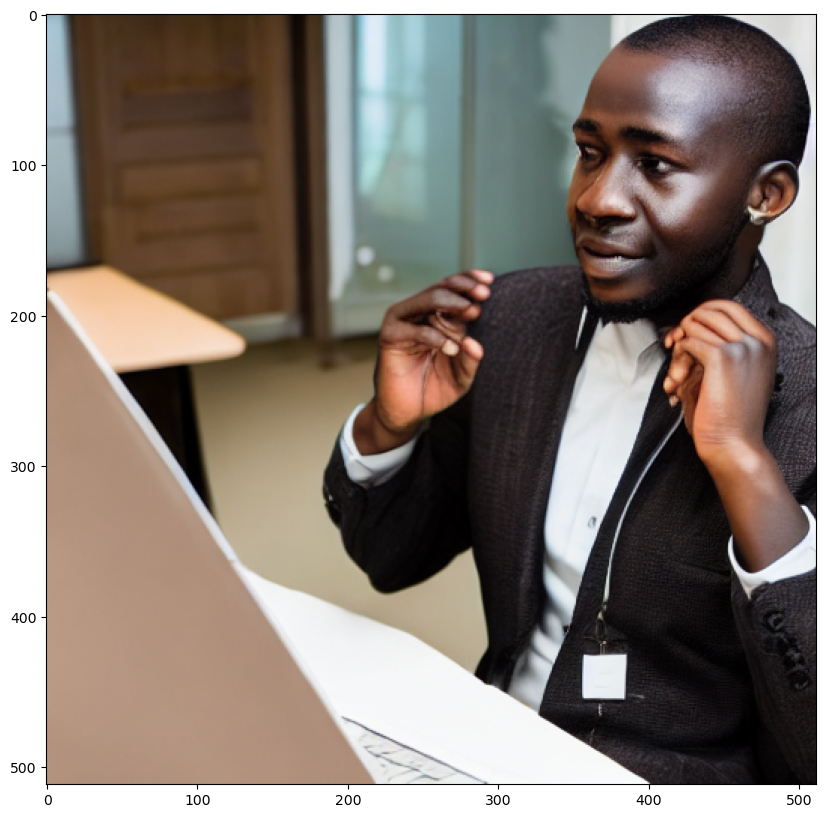

In [37]:
f,ax = plt.subplots(1,1,figsize=(20,10))
plt.imshow(grid)